# **Memorability Score Assignment - Machine Learning** - **CA684** 

This notebook is a part of CA-684 assignment. We have been given a dataset of 6000 videos consisting of various features like C3D, HMP, etc. Using these features we need to predict the memoribility of the video in terms of short term memoribility score as well as the long term memoribility score.

Importing necessary packages and libraries

In [1]:
!pip install

ERROR: You must give at least one requirement to install (see "pip help install")


In [2]:
import pandas as pd
import numpy as np
import os
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.linear_model import BayesianRidge
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import scipy as sp
from sklearn.model_selection import KFold
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Importing Progres bar

In [3]:
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
from tqdm import tqdm_notebook as tqdm

  Using cached https://github.com/chengs/tqdm/archive/colab.zip
  Created wheel for tqdm: filename=tqdm-4.28.1-py2.py3-none-any.whl size=47875 sha256=66282b83d976f3d0001800298ca40202203527045fc49608ebbe12c1944382f4
  Stored in directory: C:\Users\Dell\AppData\Local\Temp\pip-ephem-wheel-cache-5art5hnz\wheels\b5\36\d9\593e7ac06d343d0a32138fa6c402dc3a0bd31442c9fe53f76c
Successfully built tqdm
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


Fetching the data from Drive

In [0]:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [0]:
# os.chdir("/content/drive/My Drive/CA-684-ML/dev-set")

In [0]:
# check which directory we are currently in
# !pwd

/content/drive/My Drive/CA-684-ML/dev-set


In [0]:
# List all files available
# !ls

C3D		dev-set_ground-truth.csv    HMP  InceptionV3  ORB
ColorHistogram	dev-set_video-captions.txt  HOG  LBP	      README.txt


The ground truth consists the mapping of video with the target variables i.e. short term memoribility as well as long term memoribility. The annotations field is the number of people who were shown the video and memoribility signifies the percentage of them who remember the video

In [4]:
ground_truth = pd.read_csv('G:/.shortcut-targets-by-id/1UWIdExqb5P94RLqkaiODcwFC2v7g3lB2/CA684_Assignment/Dev-set/Ground-truth/ground-truth.csv', header = 0)  

In [5]:
ground_truth.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


The captions of the video can provide a textual description of the video. It would be interesting to see if we can predict the memoribility using the captions (text data). 

In [6]:
captions_dataset = pd.read_csv('G:/.shortcut-targets-by-id/1UWIdExqb5P94RLqkaiODcwFC2v7g3lB2/CA684_Assignment/Dev-set/Captions/dev-set_video-captions.txt', sep = '\t', header=None, names=['video', 'caption'] )

In [7]:
captions_dataset.head()

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters
3,video8.webm,medical-helicopter-hovers-at-airport
4,video10.webm,couple-relaxing-on-picnic-crane-shot


In [8]:
ground_truth.shape

(6000, 5)

In [9]:
captions_dataset.shape

(6000, 2)

In [10]:
merged_1 = ground_truth.merge(captions_dataset)

Merging our caption dataset with the ground truth, we get the below results

In [11]:
merged_1.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations,caption
0,video3.webm,0.924,34,0.846,13,blonde-woman-is-massaged-tilt-down
1,video4.webm,0.923,33,0.667,12,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,0.863,33,0.700,10,khr-gangsters
3,video8.webm,0.922,33,0.818,11,medical-helicopter-hovers-at-airport
4,video10.webm,0.950,34,0.900,10,couple-relaxing-on-picnic-crane-shot


Another feature that can be used to determine the memoribility can be the aesthetic features of the videos. These aesthetic features are a collection of features used in the prediction of visual aesthetics, composed of color, texture and object based descriptors, aggregated at video level by median and mean methods.

For this analysis, I am using the median features as it can provide a insight into the distribution of parameters in a non normal distributed set of values

In [0]:
# drive.mount('/content/drive/', force_remount=True)
# os.chdir("/content/drive/My Drive/CA-684-ML/aesthetic_feat_dev-set_median/")

Mounted at /content/drive/


Function to read aesthetic features   

In [12]:
def read_features_from_file(dataframe, filename):
  dataframe_1 = pd.read_csv(filename, header=None)
  dataframe_1['video'] = filename[filename.find('video'):filename.find('.txt')] + '.webm'
  dataframe = dataframe.append(dataframe_1, ignore_index=True)
  return dataframe
  

Function to read C3D feature

In [13]:
def read_c3d_from_file(dataframe, filename):
  dataframe_1 = pd.read_csv(filename, header=None, sep=' ')
  dataframe_1['video'] = filename[filename.find('video'):filename.find('.txt')] + '.webm'
  dataframe = dataframe.append(dataframe_1, ignore_index=True)
  return dataframe

Each file in this  path represents a single video and contains 109 columns. We need to read each file , store the columns in that file and map it to the video. For performing this activity we are using the below for loop


Function to read file names from a particular path
This 1st for loop is making an array with the path and name of all the files present in the above path

In [14]:
def reading_file_names(path):
  files = []
  file_number=0
  # r=root, d=directories, f = files
  for r, d, f in os.walk(path):
      for file in f:
          if '.txt' in file:
              files.append(os.path.join(r, file))
              file_number = file_number + 1
  print("total files read = " + str(file_number))
  return files

Now that we have the file array, we can proceed to read those files and build our dataset

---



In [15]:
path='D:/DCU/2nd Semester/Assignments/Machine Learning/My Assignment/dev-set_aesthetic-features/features/aesthetic_visual_features/aesthetic_feat_dev-set_median/'
files = reading_file_names(path)
dataframe_aesthetic = pd.DataFrame()
for filename in files:
  dataframe_aesthetic = read_features_from_file(dataframe_aesthetic, filename)

total files read = 6022


In [16]:
dataframe_aesthetic.head()

,0,1,2,3,4,5,6,7,8,9,...,100,101,102,103,104,105,106,107,108,video
0,0.427258,0.381448,0.582746,0.409475,0.489531,0.198180,39.394310,0.583333,0.039983,7.0,...,0.000065,0.000000,0.442575,0.347355,1.285838,0.0,-0.279630,-0.012414,0.197281,video10.webm
1,0.160579,0.238155,0.408475,0.180416,0.366411,0.345585,47.599246,0.083333,0.002136,2.0,...,-0.000081,0.116705,0.084845,0.145045,1.053873,0.0,0.719529,1.099627,1.690907,video100.webm
2,0.302134,0.330636,0.496383,0.287178,0.430446,0.246384,43.865849,0.083333,0.030235,3.0,...,0.000029,0.016424,0.350831,0.370096,1.415410,0.0,-0.126543,-0.033257,-0.062579,video1001.webm
3,0.289857,0.261362,0.534633,0.291529,0.485201,0.299456,47.997030,0.065891,0.025044,2.0,...,-0.007455,0.864074,0.473810,0.456259,1.940068,0.0,-0.114065,0.232043,0.398709,video1003.webm
4,0.637255,0.319937,0.317086,0.229754,0.261037,0.543062,52.033505,0.584848,0.084615,3.0,...,0.000404,0.183904,0.347324,0.425562,0.474023,0.0,0.292011,0.338289,-0.196339,video1004.webm


In [17]:
new_columns = list()
for colname in dataframe_aesthetic.columns:
  new_columns.append('AES_' + str(colname))
dataframe_aesthetic.columns = new_columns
dataframe_aesthetic = dataframe_aesthetic.rename(columns={'AES_video':'video'})

In [18]:
dataframe_aesthetic.head()

,AES_0,AES_1,AES_2,AES_3,AES_4,AES_5,AES_6,AES_7,AES_8,AES_9,...,AES_100,AES_101,AES_102,AES_103,AES_104,AES_105,AES_106,AES_107,AES_108,video
0,0.427258,0.381448,0.582746,0.409475,0.489531,0.198180,39.394310,0.583333,0.039983,7.0,...,0.000065,0.000000,0.442575,0.347355,1.285838,0.0,-0.279630,-0.012414,0.197281,video10.webm
1,0.160579,0.238155,0.408475,0.180416,0.366411,0.345585,47.599246,0.083333,0.002136,2.0,...,-0.000081,0.116705,0.084845,0.145045,1.053873,0.0,0.719529,1.099627,1.690907,video100.webm
2,0.302134,0.330636,0.496383,0.287178,0.430446,0.246384,43.865849,0.083333,0.030235,3.0,...,0.000029,0.016424,0.350831,0.370096,1.415410,0.0,-0.126543,-0.033257,-0.062579,video1001.webm
3,0.289857,0.261362,0.534633,0.291529,0.485201,0.299456,47.997030,0.065891,0.025044,2.0,...,-0.007455,0.864074,0.473810,0.456259,1.940068,0.0,-0.114065,0.232043,0.398709,video1003.webm
4,0.637255,0.319937,0.317086,0.229754,0.261037,0.543062,52.033505,0.584848,0.084615,3.0,...,0.000404,0.183904,0.347324,0.425562,0.474023,0.0,0.292011,0.338289,-0.196339,video1004.webm


In [19]:
dataframe_aesthetic.shape

(6022, 110)

Merging the above dataset with our captions and ground truth dataset

In [22]:
merged_dataset = merged_1.merge(dataframe_aesthetic)

In [23]:
merged_dataset.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations,caption,AES_0,AES_1,AES_2,AES_3,...,AES_99,AES_100,AES_101,AES_102,AES_103,AES_104,AES_105,AES_106,AES_107,AES_108
0,video3.webm,0.924,34,0.846,13,blonde-woman-is-massaged-tilt-down,0.180874,0.715626,0.198930,0.610453,...,-0.002154,-0.000850,0.000000,0.260845,0.294153,0.575061,0.0,0.129661,0.412381,0.788761
1,video4.webm,0.923,33,0.667,12,roulette-table-spinning-with-ball-in-closeup-shot,0.146076,0.550070,0.460729,0.424397,...,0.000007,-0.000399,0.920270,0.337932,0.382134,0.943198,0.0,0.692224,0.762354,-0.561793
2,video6.webm,0.863,33,0.700,10,khr-gangsters,0.063898,0.827439,0.211925,0.720297,...,0.002896,0.002309,0.374684,0.019155,0.187358,0.512601,0.0,0.438261,-0.219560,0.276687
3,video8.webm,0.922,33,0.818,11,medical-helicopter-hovers-at-airport,0.380539,0.134683,0.746891,0.171604,...,0.000568,0.000514,0.970656,0.435550,0.431595,1.142377,0.0,0.424483,0.326030,0.688481
4,video10.webm,0.950,34,0.900,10,couple-relaxing-on-picnic-crane-shot,0.427258,0.381448,0.582746,0.409475,...,0.005307,0.000065,0.000000,0.442575,0.347355,1.285838,0.0,-0.279630,-0.012414,0.197281


In [24]:
merged_dataset.shape

(6000, 115)

From the papers that I referred, one of the key points that I took was that C3D can be used to provide a good insight to the memoribility score. Hence, i want to use C3D as well for my predictions

Loading the C3D data 

In [0]:
# os.chdir("/content/drive/My Drive/CA-684-ML/dev-set/C3D")

In [0]:
# !pwd

/content/drive/My Drive/CA-684-ML/dev-set/C3D


In [25]:
path="G:/.shortcut-targets-by-id/1UWIdExqb5P94RLqkaiODcwFC2v7g3lB2/CA684_Assignment/Dev-set/C3D"
files = reading_file_names(path)
dataframe_C3D = pd.DataFrame()
for filename in files:
  dataframe_C3D = read_c3d_from_file(dataframe_C3D, filename)

total files read = 6000


In [26]:
dataframe_C3D.head()

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,video
0,0.010858,0.010386,0.000000,0.000000e+00,0.000000e+00,0.000000,2.700000e-07,0.000000,1.000000e-08,3.400000e-07,...,0.000000,1.700000e-07,0.000000,0.000000e+00,1.000000e-08,1.300000e-06,2.600000e-06,8.000000e-08,NaN,video6632.webm
1,0.000200,0.000065,0.993807,2.000000e-07,4.700000e-07,0.000073,3.700000e-06,0.000337,6.710000e-06,2.290000e-06,...,0.000002,5.800000e-06,0.000001,1.490000e-06,1.170000e-05,1.500000e-07,8.300000e-07,1.060000e-04,NaN,video6634.webm
2,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.120000e-06,NaN,video6633.webm
3,0.005959,0.004765,0.003757,5.787100e-04,7.344000e-05,0.000129,4.665300e-04,0.010266,3.028100e-04,2.196500e-04,...,0.004137,3.670390e-02,0.000767,3.692100e-04,1.251980e-02,8.422000e-05,1.159825e-02,1.155040e-03,NaN,video6645.webm
4,0.005782,0.000306,0.004011,1.007000e-05,1.034000e-05,0.000002,3.160000e-06,0.000003,1.984000e-05,5.750000e-06,...,0.000004,6.818350e-03,0.000005,5.000000e-08,2.088000e-05,1.271750e-03,4.862200e-04,1.965000e-05,NaN,video6643.webm


we see we have an extra column which has NaN as a value, Lets delete this column as this is due to trailing spaces in the data 

In [27]:
dataframe_C3D = dataframe_C3D.drop(columns=101)

In [28]:
dataframe_C3D.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,video
0,0.010858,0.010386,0.000000,0.000000e+00,0.000000e+00,0.000000,2.700000e-07,0.000000,1.000000e-08,3.400000e-07,...,0.000000,0.000000,1.700000e-07,0.000000,0.000000e+00,1.000000e-08,1.300000e-06,2.600000e-06,8.000000e-08,video6632.webm
1,0.000200,0.000065,0.993807,2.000000e-07,4.700000e-07,0.000073,3.700000e-06,0.000337,6.710000e-06,2.290000e-06,...,0.000010,0.000002,5.800000e-06,0.000001,1.490000e-06,1.170000e-05,1.500000e-07,8.300000e-07,1.060000e-04,video6634.webm
2,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.120000e-06,video6633.webm
3,0.005959,0.004765,0.003757,5.787100e-04,7.344000e-05,0.000129,4.665300e-04,0.010266,3.028100e-04,2.196500e-04,...,0.003992,0.004137,3.670390e-02,0.000767,3.692100e-04,1.251980e-02,8.422000e-05,1.159825e-02,1.155040e-03,video6645.webm
4,0.005782,0.000306,0.004011,1.007000e-05,1.034000e-05,0.000002,3.160000e-06,0.000003,1.984000e-05,5.750000e-06,...,0.000002,0.000004,6.818350e-03,0.000005,5.000000e-08,2.088000e-05,1.271750e-03,4.862200e-04,1.965000e-05,video6643.webm


Merging the above dataset with our previously created dataset, but before we need to change the name of the columns 

In [29]:
new_columns = list()
for colname in dataframe_C3D.columns:
  new_columns.append('C3D_' + str(colname))
dataframe_C3D.columns = new_columns
dataframe_C3D = dataframe_C3D.rename(columns={'C3D_video':'video'})

In [30]:
dataframe_C3D.head()

,C3D_0,C3D_1,C3D_2,C3D_3,C3D_4,C3D_5,C3D_6,C3D_7,C3D_8,C3D_9,...,C3D_92,C3D_93,C3D_94,C3D_95,C3D_96,C3D_97,C3D_98,C3D_99,C3D_100,video
0,0.010858,0.010386,0.000000,0.000000e+00,0.000000e+00,0.000000,2.700000e-07,0.000000,1.000000e-08,3.400000e-07,...,0.000000,0.000000,1.700000e-07,0.000000,0.000000e+00,1.000000e-08,1.300000e-06,2.600000e-06,8.000000e-08,video6632.webm
1,0.000200,0.000065,0.993807,2.000000e-07,4.700000e-07,0.000073,3.700000e-06,0.000337,6.710000e-06,2.290000e-06,...,0.000010,0.000002,5.800000e-06,0.000001,1.490000e-06,1.170000e-05,1.500000e-07,8.300000e-07,1.060000e-04,video6634.webm
2,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.120000e-06,video6633.webm
3,0.005959,0.004765,0.003757,5.787100e-04,7.344000e-05,0.000129,4.665300e-04,0.010266,3.028100e-04,2.196500e-04,...,0.003992,0.004137,3.670390e-02,0.000767,3.692100e-04,1.251980e-02,8.422000e-05,1.159825e-02,1.155040e-03,video6645.webm
4,0.005782,0.000306,0.004011,1.007000e-05,1.034000e-05,0.000002,3.160000e-06,0.000003,1.984000e-05,5.750000e-06,...,0.000002,0.000004,6.818350e-03,0.000005,5.000000e-08,2.088000e-05,1.271750e-03,4.862200e-04,1.965000e-05,video6643.webm


In [31]:
merged_dataset = merged_dataset.merge(dataframe_C3D)

In [32]:
merged_dataset.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations,caption,AES_0,AES_1,AES_2,AES_3,...,C3D_91,C3D_92,C3D_93,C3D_94,C3D_95,C3D_96,C3D_97,C3D_98,C3D_99,C3D_100
0,video3.webm,0.924,34,0.846,13,blonde-woman-is-massaged-tilt-down,0.180874,0.715626,0.198930,0.610453,...,0.001042,0.000161,0.000257,0.046617,0.000156,0.000006,0.000537,0.000339,0.008437,0.000470
1,video4.webm,0.923,33,0.667,12,roulette-table-spinning-with-ball-in-closeup-shot,0.146076,0.550070,0.460729,0.424397,...,0.000582,0.000393,0.000864,0.000947,0.000136,0.000007,0.000360,0.000159,0.001025,0.000020
2,video6.webm,0.863,33,0.700,10,khr-gangsters,0.063898,0.827439,0.211925,0.720297,...,0.000224,0.000003,0.000031,0.002538,0.000104,0.000005,0.000064,0.005380,0.001027,0.001384
3,video8.webm,0.922,33,0.818,11,medical-helicopter-hovers-at-airport,0.380539,0.134683,0.746891,0.171604,...,0.000046,0.000009,0.000023,0.000053,0.000048,0.000019,0.000001,0.000004,0.000380,0.000029
4,video10.webm,0.950,34,0.900,10,couple-relaxing-on-picnic-crane-shot,0.427258,0.381448,0.582746,0.409475,...,0.000037,0.000690,0.000171,0.000231,0.000637,0.000040,0.000061,0.000075,0.000002,0.001323


Now that we have our final merged dataset, we need to extract features from it. Since we cannot input text directly into our model, we need to first convert this text into numerical form


### Converting Captions into Features

Lets begin with cleaning our data.

Converting the captions into lowercase

In [33]:
merged_dataset['caption'] = merged_dataset['caption'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [34]:
merged_dataset['caption'].head()

0                   blonde-woman-is-massaged-tilt-down
1    roulette-table-spinning-with-ball-in-closeup-shot
2                                        khr-gangsters
3                 medical-helicopter-hovers-at-airport
4                 couple-relaxing-on-picnic-crane-shot
Name: caption, dtype: object

we can see that our text is '-' separated, we need to replace it with ' '  for better evaluation

In [35]:
merged_dataset['caption'] = merged_dataset['caption'].str.replace('-',' ')

In [36]:
merged_dataset['caption'].head()

0                   blonde woman is massaged tilt down
1    roulette table spinning with ball in closeup shot
2                                        khr gangsters
3                 medical helicopter hovers at airport
4                 couple relaxing on picnic crane shot
Name: caption, dtype: object

Let us remove all the punctuations from our captions 

In [37]:
#Removal of punctuations 
merged_dataset['caption'] = merged_dataset['caption'].str.replace('[^\w\s]','')

In [38]:
merged_dataset['caption'].head()

0                   blonde woman is massaged tilt down
1    roulette table spinning with ball in closeup shot
2                                        khr gangsters
3                 medical helicopter hovers at airport
4                 couple relaxing on picnic crane shot
Name: caption, dtype: object

Removing stop words from our dataset

In [39]:
#Removal of stop words
stop = stopwords.words('english')
merged_dataset['caption'] = merged_dataset['caption'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
merged_dataset['caption'].head()

0                   blonde woman massaged tilt
1    roulette table spinning ball closeup shot
2                                khr gangsters
3            medical helicopter hovers airport
4            couple relaxing picnic crane shot
Name: caption, dtype: object

Let us now lematize our captions, this will transform all words into their root form, such that the meaning of the word is retained as well as number of fetaures is reduced

In [40]:
#Lemmatizing our captions 
lemmatizer = WordNetLemmatizer() 
merged_dataset['caption'] = merged_dataset['caption'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
merged_dataset['caption'].head()

0                   blonde woman massaged tilt
1    roulette table spinning ball closeup shot
2                                 khr gangster
3            medical helicopter hovers airport
4            couple relaxing picnic crane shot
Name: caption, dtype: object

Removing digits from our data 

In [41]:
merged_dataset['caption'] = merged_dataset['caption'].str.replace('[0-9]','')

In [42]:
merged_dataset['caption'].head()

0                   blonde woman massaged tilt
1    roulette table spinning ball closeup shot
2                                 khr gangster
3            medical helicopter hovers airport
4            couple relaxing picnic crane shot
Name: caption, dtype: object

All the above steps can be encapsulated into a function, which can be  used later on our test data 

In [43]:
def cleaning_captions(merged_dataset):
  merged_dataset['caption'] = merged_dataset['caption'].apply(lambda x: " ".join(x.lower() for x in x.split()))
  merged_dataset['caption'] = merged_dataset['caption'].str.replace('-',' ')
  merged_dataset['caption'] = merged_dataset['caption'].str.replace('[^\w\s]','')
  stop = stopwords.words('english')
  merged_dataset['caption'] = merged_dataset['caption'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
  lemmatizer = WordNetLemmatizer() 
  merged_dataset['caption'] = merged_dataset['caption'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
  merged_dataset['caption'] = merged_dataset['caption'].str.replace('[0-9]','')
  return merged_dataset['caption']

## Exploratory Data Analysis 

Now that we have our dataset ready, Let us perform some data exploration activities

Let's see the top 10 video captions with highest short term memoribility

In [44]:
merged_dataset.sort_values('short-term_memorability',ascending=False)[['caption','short-term_memorability']].head(10)

,caption,short-term_memorability
651,camera move beared man shovel taking breather ...,0.989
3910,mather daughter enjoying movie tablet,0.987
1599,happy stylish elegant young couple welcoming n...,0.987
1903,head big yellow eel,0.986
2089,funny little boy sitting desk eating apple dra...,0.986
4024,khr western unloadinggun,0.986
1771,astronaut outer space backdrop planet earth el...,0.986
4880,young asian woman snowfall slowmotion,0.986
4969,giraffe fighting,0.985
3531,runner woman running park exercising outdoors ...,0.985


Let's see the top 10 video captions with highest long term memoribility

In [45]:
merged_dataset.sort_values('long-term_memorability',ascending=False)[['caption','long-term_memorability']].head(10)

,caption,long-term_memorability
4304,nurse moving patient one another,1.0
4361,cute blond woman lifestyle scene white luxury ...,1.0
424,female doctor showing patient x ray chest usin...,1.0
1253,people walking snowy street,1.0
1247,kitten playing string,1.0
4396,father little son running along beach playing ...,1.0
2735,giraffe fighting,1.0
432,mother daughter drinking healthy juice looking...,1.0
434,scientist us pipette transfer sample,1.0
4409,young couple playing son seaside swinging air ...,1.0


Let's compare the words that have been used for reviews with high memoribility for short term and low memoribility for short term

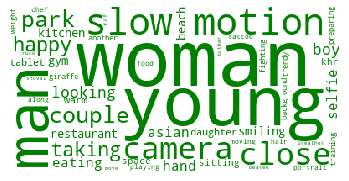

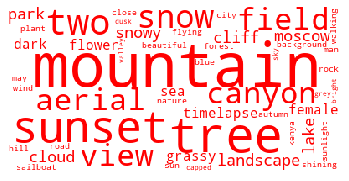

In [46]:
word_string=" ".join(merged_dataset.sort_values('short-term_memorability', ascending=False)[['caption']].head(50)['caption'].str.lower())
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=50, color_func=(lambda *args, **kwargs: (0,128,0))
                         ).generate(word_string)
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

word_string=" ".join(merged_dataset.sort_values('short-term_memorability')[['caption']].head(50)['caption'].str.lower())
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=50, color_func=(lambda *args, **kwargs: (255,0,0))
                         ).generate(word_string)
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

From the above graphs we can see that most  of the videos having high short memoribility have words woman, couple, man in it, whereas videos with less memorability score have words like mountain, tree, etc in it. This might signify that human object is far more memorable than a landscape or nature related video. 

Let us see if this assumption holds true for long term memorability

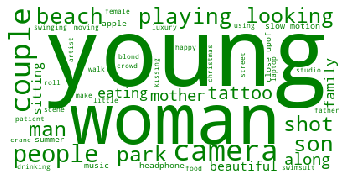

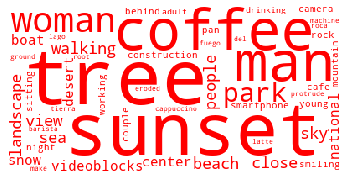

In [47]:
word_string=" ".join(merged_dataset.sort_values('long-term_memorability', ascending=False)[['caption']].head(50)['caption'].str.lower())
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=50, color_func=(lambda *args, **kwargs: (0,128,0))
                         ).generate(word_string)
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

word_string=" ".join(merged_dataset.sort_values('long-term_memorability')[['caption']].head(50)['caption'].str.lower())
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=50, color_func=(lambda *args, **kwargs: (255,0,0))
                         ).generate(word_string)
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We can see a similar pattern in long term as well

Let us see if short term memoribility and long term  memoribility follow the same pattern 

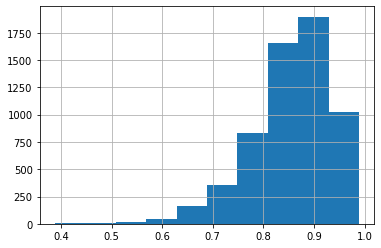

In [48]:
merged_dataset['short-term_memorability'].hist()

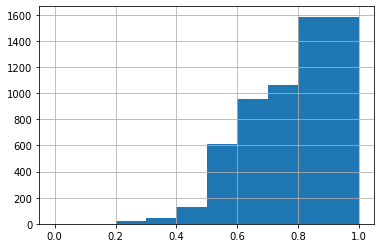

In [49]:
merged_dataset['long-term_memorability'].hist()

From the distributions we can see that both the distribution are skewed, they seem to follow a similar pattern. Videos are more memorable in short term than long term

## Building Model

Using k-fold cross validation technique on our model

In [50]:
kf = KFold(n_splits=10)

Function to get the correlation value of a model 

In [51]:
def get_corr_for_model(model, traing_caption, test_caption, y_train, y_test):
  model.fit(traing_caption, y_train)
  predictions_validation = model.predict(test_caption)
  corr, p_value = spearmanr(y_test, predictions_validation)
  return corr

Using the bag of words technique for vectorising our data, we can use the tfidf vectoriser as it gives a better performance than regular count vectoriser

In [52]:
def vectorize_data(X_train, X_test):
  bow = TfidfVectorizer(max_features=1000, lowercase=True, ngram_range=(1,2),analyzer = "word")
  train_bow = bow.fit(X_train['caption'])
  train_caption = train_bow.transform(X_train['caption'])
  test_caption = train_bow.transform(X_test['caption'])
  return train_caption, test_caption

Separating the predictor and target variables

In [53]:
training_set =  merged_dataset.drop(columns=['short-term_memorability','long-term_memorability','nb_short-term_annotations','nb_long-term_annotations'])
testing_set_short_term = merged_dataset['short-term_memorability'].to_frame()
testing_set_long_term = merged_dataset['long-term_memorability'].to_frame()

Applying K-fold validation technique to evaluate the performance of our model.  The method get_corr_for_model returns the spearman rank score for each fold

### Caption based feature model

Comparing the results of Bayesian Ridge regression and Support Vector Regression for caption

In [54]:
scores_svr_short_term = []
scores_svr_long_term = []
scores_BR_short_term = []
scores_BR_long_term = []

for train_index, test_index in kf.split(training_set):
  X_train, X_test, y_train, y_test =training_set.iloc[train_index, :], training_set.iloc[test_index, :],testing_set_long_term['long-term_memorability'][train_index],testing_set_long_term['long-term_memorability'][test_index]
  training_caption, testing_caption  = vectorize_data(X_train, X_test)
  scores_svr_long_term.append(get_corr_for_model(SVR(kernel='linear'), training_caption, testing_caption, y_train, y_test))
  scores_BR_long_term.append(get_corr_for_model(BayesianRidge(), training_caption.toarray(), testing_caption.toarray(), y_train, y_test))
  X_train, X_test, y_train, y_test =training_set.iloc[train_index, :], training_set.iloc[test_index, :],testing_set_short_term['short-term_memorability'][train_index],testing_set_short_term['short-term_memorability'][test_index]
  training_caption, testing_caption  = vectorize_data(X_train, X_test)
  scores_BR_short_term.append(get_corr_for_model(BayesianRidge(), training_caption.toarray(), testing_caption.toarray(), y_train, y_test))
  scores_svr_short_term.append(get_corr_for_model(SVR(kernel='linear'), training_caption, testing_caption, y_train, y_test))
  

Checking the average of the various scores

In [55]:
avg_score_short_term_SVR = sum(scores_svr_short_term)/len(scores_svr_short_term)
print("average score for SVR short term memory = " + str(avg_score_short_term_SVR))
avg_score_long_term_SVR = sum(scores_svr_long_term)/len(scores_svr_long_term)
print("average score for SVR long term memory = " + str(avg_score_long_term_SVR))

avg_score_short_term_BR = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory = " + str(avg_score_short_term_BR))
avg_score_long_term_BR = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory = " + str(avg_score_long_term_BR))

average score for SVR short term memory = 0.32223194778379
average score for SVR long term memory = 0.12873606856939476
average score for Bayesian Ridge short term memory = 0.4225770935654337
average score for Bayesian Ridge long term memory = 0.18740171816207604


Here we can see Bayesian Ridge is performing better on our dataset, Let us use that for our predictions of long and short term memoribility using text data 

### Video based features model

Now let us work with the video based features in our dataset 

Checking the correlation between the data

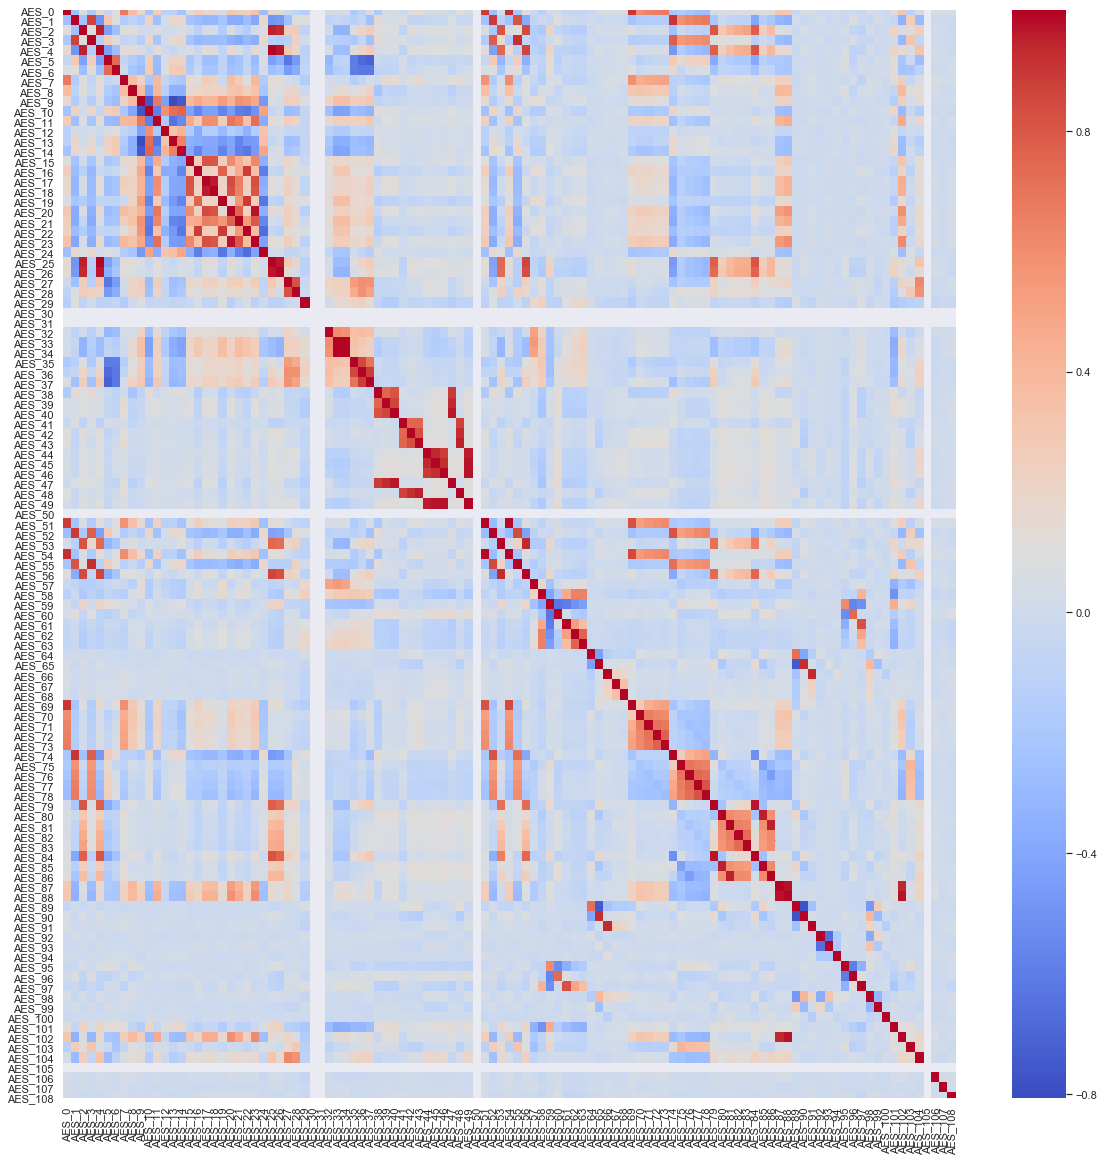

In [56]:
corr_data = training_set.drop(columns='video')
corr_data_2 = corr_data[corr_data.columns[corr_data.columns.str.startswith('AES')]]
corre = corr_data_2.corr()
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(corre,
            cmap='coolwarm',
            xticklabels=corre.columns.values,
            yticklabels=corre.columns.values)


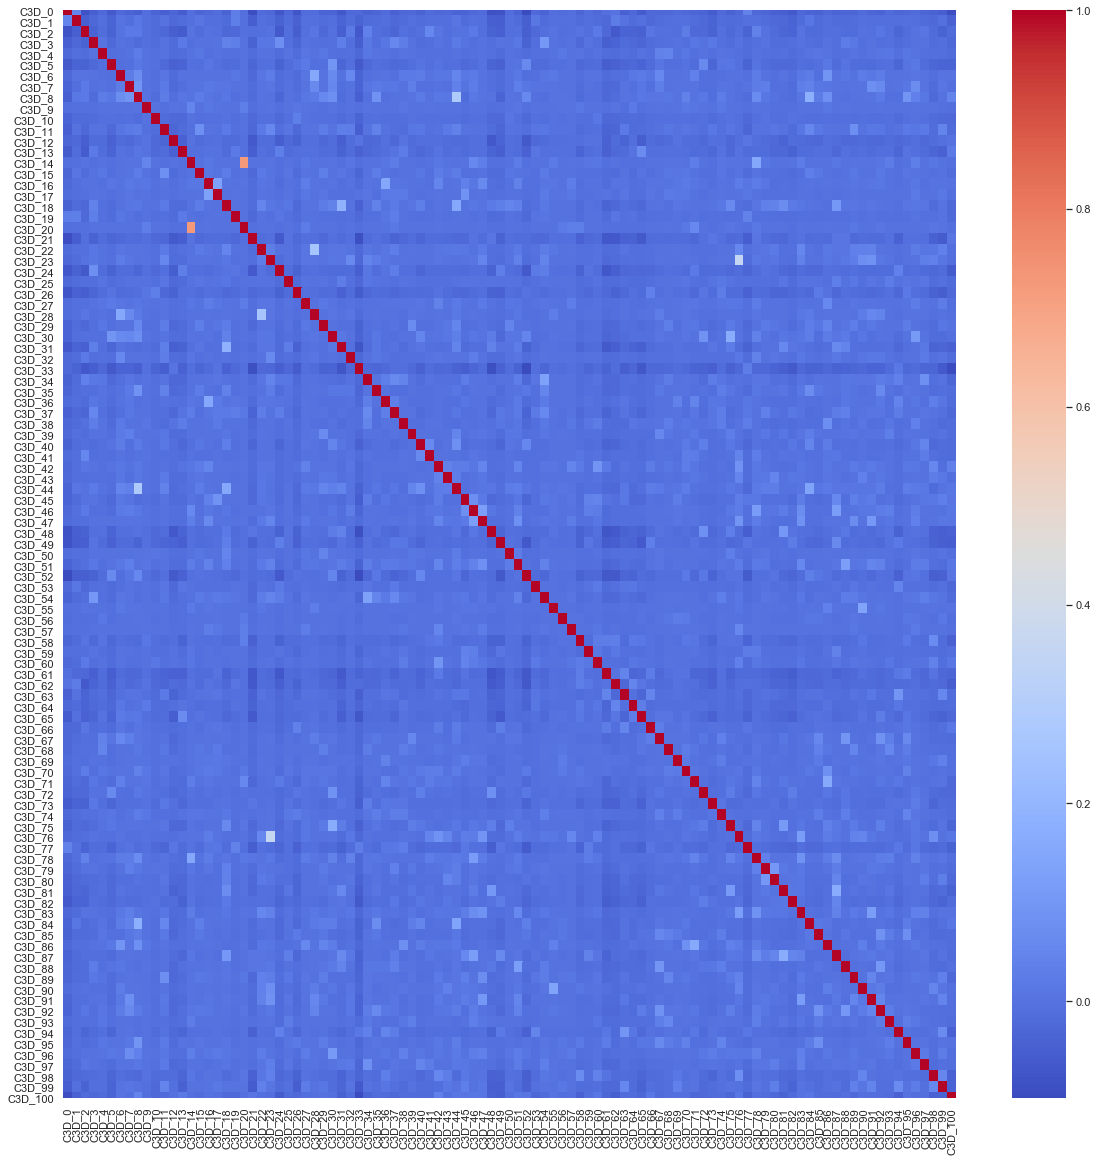

In [57]:
corr_data = training_set.drop(columns='video')
corr_data_2 = corr_data[corr_data.columns[corr_data.columns.str.startswith('C3D')]]
corre = corr_data_2.corr()
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(corre,
            cmap='coolwarm',
            xticklabels=corre.columns.values,
            yticklabels=corre.columns.values)


From the correlation matrix we can see that some of the variables have high correlation for Aesthetic values

**Aesthetic Features**

In [58]:
Aesthetic_features = training_set[training_set.columns[training_set.columns.str.startswith('AES')]]

In [59]:
Aesthetic_features.head()

,AES_0,AES_1,AES_2,AES_3,AES_4,AES_5,AES_6,AES_7,AES_8,AES_9,...,AES_99,AES_100,AES_101,AES_102,AES_103,AES_104,AES_105,AES_106,AES_107,AES_108
0,0.180874,0.715626,0.198930,0.610453,0.121610,0.692880,55.008914,0.103175,0.001049,2.0,...,-0.002154,-0.000850,0.000000,0.260845,0.294153,0.575061,0.0,0.129661,0.412381,0.788761
1,0.146076,0.550070,0.460729,0.424397,0.341807,0.398212,47.307755,0.119048,0.001859,2.0,...,0.000007,-0.000399,0.920270,0.337932,0.382134,0.943198,0.0,0.692224,0.762354,-0.561793
2,0.063898,0.827439,0.211925,0.720297,0.129499,0.722464,60.535453,0.069048,0.000423,1.0,...,0.002896,0.002309,0.374684,0.019155,0.187358,0.512601,0.0,0.438261,-0.219560,0.276687
3,0.380539,0.134683,0.746891,0.171604,0.697045,0.452995,47.827289,0.580247,0.008550,2.0,...,0.000568,0.000514,0.970656,0.435550,0.431595,1.142377,0.0,0.424483,0.326030,0.688481
4,0.427258,0.381448,0.582746,0.409475,0.489531,0.198180,39.394310,0.583333,0.039983,7.0,...,0.005307,0.000065,0.000000,0.442575,0.347355,1.285838,0.0,-0.279630,-0.012414,0.197281


In [60]:
X = Aesthetic_features

Applying K fold validation technique using Bayesian Ridge Regression on aesthetic features 

We are using Bayesian ridge regression as we have a variety of features and Bayesian ridge will regularize the data and apply bayesian probability to get our target variables

In [61]:
scores_BR_short_term = []
scores_BR_long_term = []

for train_index, test_index in kf.split(X):
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_long_term['long-term_memorability'][train_index],testing_set_long_term['long-term_memorability'][test_index]
  scores_BR_long_term.append(get_corr_for_model(BayesianRidge(), X_train, X_test, y_train, y_test))
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_short_term['short-term_memorability'][train_index],testing_set_short_term['short-term_memorability'][test_index]
  scores_BR_short_term.append(get_corr_for_model(BayesianRidge(), X_train, X_test, y_train, y_test))

In [62]:
avg_score_short_term_BR_AF = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory = " + str(avg_score_short_term_BR_AF))
avg_score_long_term_BR_AF = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory = " + str(avg_score_long_term_BR_AF))

average score for Bayesian Ridge short term memory = 0.2577014056332336
average score for Bayesian Ridge long term memory = 0.07080779177158154


**C3D features**

Let us work on C3D features 

In [63]:
C3D_features = training_set[training_set.columns[training_set.columns.str.startswith('C3D')]]

In [64]:
C3D_features.head()

,C3D_0,C3D_1,C3D_2,C3D_3,C3D_4,C3D_5,C3D_6,C3D_7,C3D_8,C3D_9,...,C3D_91,C3D_92,C3D_93,C3D_94,C3D_95,C3D_96,C3D_97,C3D_98,C3D_99,C3D_100
0,0.020249,0.001578,0.000826,0.000945,0.000063,0.000003,0.001162,0.000097,0.000022,0.000010,...,0.001042,0.000161,0.000257,0.046617,0.000156,0.000006,0.000537,0.000339,0.008437,0.000470
1,0.000118,0.000891,0.000188,0.000045,0.000063,0.000002,0.000641,0.000011,0.000017,0.000014,...,0.000582,0.000393,0.000864,0.000947,0.000136,0.000007,0.000360,0.000159,0.001025,0.000020
2,0.011765,0.000746,0.000784,0.000013,0.000007,0.000028,0.000041,0.000014,0.000041,0.000083,...,0.000224,0.000003,0.000031,0.002538,0.000104,0.000005,0.000064,0.005380,0.001027,0.001384
3,0.000223,0.000165,0.000007,0.000016,0.000005,0.000014,0.000154,0.000008,0.000004,0.000009,...,0.000046,0.000009,0.000023,0.000053,0.000048,0.000019,0.000001,0.000004,0.000380,0.000029
4,0.000090,0.000615,0.003436,0.001281,0.003551,0.000313,0.000042,0.000018,0.000157,0.000117,...,0.000037,0.000690,0.000171,0.000231,0.000637,0.000040,0.000061,0.000075,0.000002,0.001323


Applying Bayesian Ridge model on C3D features using KFold 

In [65]:
X = C3D_features
scores_BR_short_term = []
scores_BR_long_term = []

for train_index, test_index in kf.split(X):
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_long_term['long-term_memorability'][train_index],testing_set_long_term['long-term_memorability'][test_index]
  scores_BR_long_term.append(get_corr_for_model(BayesianRidge(), X_train, X_test, y_train, y_test))
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_short_term['short-term_memorability'][train_index],testing_set_short_term['short-term_memorability'][test_index]
  scores_BR_short_term.append(get_corr_for_model(BayesianRidge(), X_train, X_test, y_train, y_test))

Checking scores of our model

In [66]:
avg_score_short_term_BR_C3D = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory = " + str(avg_score_short_term_BR_C3D))
avg_score_long_term_BR_C3D = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory = " + str(avg_score_long_term_BR_C3D))

average score for Bayesian Ridge short term memory = 0.28408236759096844
average score for Bayesian Ridge long term memory = 0.128516651068326


**Bayesian Ridge on combined dataset (captions + aesthetic + C3D)**

We can see that Bayesian ridge is performing well for C3D, Aesthetic and captions individually. Let us try to run Bayesian Ridge on the complete model

In [67]:
X=training_set.drop(columns='video')

scores_BR_short_term = []
scores_BR_long_term = []

for train_index, test_index in kf.split(X):
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_long_term['long-term_memorability'][train_index],testing_set_long_term['long-term_memorability'][test_index]
  training_caption, testing_caption  = vectorize_data(X_train[['caption']], X_test[['caption']])
  X_train = X_train.drop(columns='caption')
  X_test = X_test.drop(columns='caption')
  final_train = sp.sparse.hstack((training_caption,X_train.values.astype(float)),format='csr')
  final_test = sp.sparse.hstack((testing_caption,X_test.values),format='csr')
  scores_BR_long_term.append(get_corr_for_model(BayesianRidge(), final_train.toarray(), final_test.toarray(), y_train, y_test))
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_short_term['short-term_memorability'][train_index],testing_set_short_term['short-term_memorability'][test_index]
  training_caption, testing_caption  = vectorize_data(X_train[['caption']], X_test[['caption']])
  X_train = X_train.drop(columns='caption')
  X_test = X_test.drop(columns='caption')
  final_train = sp.sparse.hstack((training_caption,X_train.values.astype(float)),format='csr')
  final_test = sp.sparse.hstack((testing_caption,X_test.values.astype(float)),format='csr')
  scores_BR_short_term.append(get_corr_for_model(BayesianRidge(), final_train.toarray(), final_test.toarray(), y_train, y_test))

Checking average score 

In [68]:
avg_score_short_term_BR_combined = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory = " + str(avg_score_short_term_BR_combined))
avg_score_long_term_BR_combined = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory = " + str(avg_score_long_term_BR_combined))

average score for Bayesian Ridge short term memory = 0.4318639968963205
average score for Bayesian Ridge long term memory = 0.17191436369612453


From the results, we can see that our short term memoribility score has improved, but our long term memory score has reduced compared to the score of just captions. By applying an ensemble technique I wil be able to assign weights to my models and use it for prediction. Hence applying ensemble technique using weighted average technique

### **Ensemble model building**

Function to build model on captions

In [69]:
def model_for_captions(X_train, X_test, y_train, y_test):
  training_caption, testing_caption  = vectorize_data(X_train[['caption']], X_test[['caption']])
  model = BayesianRidge()
  model.fit(training_caption.toarray(), y_train)
  predictions_validation = model.predict(testing_caption.toarray())
  return predictions_validation

Function to build model on Aesthetics

In [70]:
def model_for_AES(X_train, X_test, y_train, y_test):
  Aesthetic_features_train = X_train[X_train.columns[X_train.columns.str.startswith('AES')]]
  Aesthetic_features_test = X_test[X_test.columns[X_test.columns.str.startswith('AES')]]
  model = BayesianRidge()
  model.fit(Aesthetic_features_train, y_train)
  predictions_validation = model.predict(Aesthetic_features_test)
  return predictions_validation

Function to build model on C3D

In [71]:
def model_for_C3D(X_train, X_test, y_train, y_test):
  C3D_features_train = X_train[X_train.columns[X_train.columns.str.startswith('C3D')]]
  C3D_features_test = X_test[X_test.columns[X_test.columns.str.startswith('C3D')]]
  model = BayesianRidge()
  model.fit(C3D_features_train, y_train)
  predictions_validation = model.predict(C3D_features_test)
  return predictions_validation

Function to model for long term memorability

In [72]:
def predict_for_long_term(X_train, X_test, y_train, y_test):
  predictions_for_captions_long_term = model_for_captions(X_train, X_test, y_train, y_test)
  predictions_for_AES_long_term =  model_for_AES(X_train, X_test, y_train, y_test)
  predictions_for_C3D_long_term = model_for_C3D(X_train, X_test, y_train, y_test)
  Prediction_final = 0.5*predictions_for_captions_long_term + 0.1*predictions_for_AES_long_term + 0.4*predictions_for_C3D_long_term
  return Prediction_final

Function to model for short term memorability

In [73]:
def predict_for_short_term(X_train, X_test, y_train, y_test):
  predictions_for_captions_short_term = model_for_captions(X_train, X_test, y_train, y_test)
  predictions_for_AES_short_term =  model_for_AES(X_train, X_test, y_train, y_test)
  predictions_for_C3D_short_term = model_for_C3D(X_train, X_test, y_train, y_test)
  Prediction_final = 0.6*predictions_for_captions_short_term + 0.1*predictions_for_AES_short_term + 0.3*predictions_for_C3D_short_term
  return Prediction_final

Function to get Spearman correlation value for the results

In [74]:
def get_spearman_correlation(Predictions,y_test):
  corr, p_value = spearmanr(y_test, Predictions)
  return corr

Applying KFolds technique

In [75]:
kf_ensemble = KFold(n_splits=10)

Applying ensemble model on training and validation set 

In [76]:
X=training_set.drop(columns='video')

scores_BR_short_term = []
scores_BR_long_term = []

for train_index, test_index in kf_ensemble.split(X):
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_long_term['long-term_memorability'][train_index],testing_set_long_term['long-term_memorability'][test_index]
  Prediction_final_long_term = predict_for_long_term(X_train, X_test, y_train, y_test)
  scores_BR_long_term.append(get_spearman_correlation(Prediction_final_long_term,y_test))
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_short_term['short-term_memorability'][train_index],testing_set_short_term['short-term_memorability'][test_index]
  Prediction_final_short_term = predict_for_short_term(X_train, X_test, y_train, y_test)
  scores_BR_short_term.append(get_spearman_correlation(Prediction_final_short_term,y_test))

Getting the average score, various simulations were run to find the optimal value for the weights

In [77]:
# weights 0.8, 0.1, 0.1 --- captions, AES, C3D
avg_score_short_term_BR_ensemble = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory ensemble model = " + str(avg_score_short_term_BR_ensemble))
avg_score_long_term_BR_ensemble = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory ensemble model = " + str(avg_score_long_term_BR_ensemble))

average score for Bayesian Ridge short term memory ensemble model = 0.43885267490313196
average score for Bayesian Ridge long term memory ensemble model = 0.19873081506978754


In [78]:
# weights 0.75, 0.1, 0.15 --- captions, AES, C3D
avg_score_short_term_BR_ensemble = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory ensemble model = " + str(avg_score_short_term_BR_ensemble))
avg_score_long_term_BR_ensemble = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory ensemble model = " + str(avg_score_long_term_BR_ensemble))

average score for Bayesian Ridge short term memory ensemble model = 0.43885267490313196
average score for Bayesian Ridge long term memory ensemble model = 0.19873081506978754


In [79]:
# weights 0.7, 0.1, 0.2 --- captions, AES, C3D
## weights 0.7, 0.1, 0.2 --- captions, AES, C3D
avg_score_short_term_BR_ensemble = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory ensemble model = " + str(avg_score_short_term_BR_ensemble))
avg_score_long_term_BR_ensemble = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory ensemble model = " + str(avg_score_long_term_BR_ensemble))

average score for Bayesian Ridge short term memory ensemble model = 0.43885267490313196
average score for Bayesian Ridge long term memory ensemble model = 0.19873081506978754


In [80]:
# weights 0.6, 0.1, 0.3 --- captions, AES, C3D
## weights 0.6, 0.1, 0.3 --- captions, AES, C3D
avg_score_short_term_BR_ensemble = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory ensemble model = " + str(avg_score_short_term_BR_ensemble))
avg_score_long_term_BR_ensemble = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory ensemble model = " + str(avg_score_long_term_BR_ensemble))

average score for Bayesian Ridge short term memory ensemble model = 0.43885267490313196
average score for Bayesian Ridge long term memory ensemble model = 0.19873081506978754


In [81]:
# weights 0.5, 0.1, 0.4 --- captions, AES, C3D
## weights 0.5, 0.1, 0.4 --- captions, AES, C3D
avg_score_short_term_BR_ensemble = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory ensemble model = " + str(avg_score_short_term_BR_ensemble))
avg_score_long_term_BR_ensemble = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory ensemble model = " + str(avg_score_long_term_BR_ensemble))

average score for Bayesian Ridge short term memory ensemble model = 0.43885267490313196
average score for Bayesian Ridge long term memory ensemble model = 0.19873081506978754


We can see that our performance for long term increased but short term deteriorated, hence we should use weights 0.6, 0.1, 0.3 for short term, and 0.5, 0.1 and 0.4 for long term

In [82]:
# weights 0.6, 0.1, 0.3 --- captions, AES, C3D
## weights 0.5, 0.1, 0.4 --- captions, AES, C3D
avg_score_short_term_BR_ensemble = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory ensemble model = " + str(avg_score_short_term_BR_ensemble))
avg_score_long_term_BR_ensemble = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory ensemble model = " + str(avg_score_long_term_BR_ensemble))

average score for Bayesian Ridge short term memory ensemble model = 0.43885267490313196
average score for Bayesian Ridge long term memory ensemble model = 0.19873081506978754


Now that I have decided weights for my model, we will go forward and predict for our test data set that has been shared to us without the target variables  

## Model on Test Data

Loading our test data 

In [0]:
# drive.mount('/content/drive/', force_remount=True)
# os.chdir("/content/drive/My Drive/")

Mounted at /content/drive/


In [0]:
path="D:/DCU/2nd Semester/Assignments/Machine Learning/My Assignment/dev-set_aesthetic-features/features/aesthetic_visual_features/aesthetic_feat_dev-set_median/"
files = reading_file_names(path)
dataframe_aesthetic_test = pd.DataFrame()
for filename in files:
  dataframe_aesthetic_test = read_features_from_file(dataframe_aesthetic_test, filename)

total files read = 2000


In [0]:
new_columns = list()
for colname in dataframe_aesthetic_test.columns:
  new_columns.append('AES_' + str(colname))
dataframe_aesthetic_test.columns = new_columns
dataframe_aesthetic_test = dataframe_aesthetic_test.rename(columns={'AES_video':'video'})

In [0]:
dataframe_aesthetic_test.head()

,AES_0,AES_1,AES_2,AES_3,AES_4,AES_5,AES_6,AES_7,AES_8,AES_9,...,AES_100,AES_101,AES_102,AES_103,AES_104,AES_105,AES_106,AES_107,AES_108,video
0,0.270589,0.354729,0.516568,0.303221,0.446719,0.251911,41.882477,0.102564,0.014481,7.0,...,0.000031,0.072940,0.382474,0.531038,1.933607,0.0,-0.610044,0.356858,-0.018747,video9901.webm
1,0.071170,0.646879,0.600170,0.636162,0.429450,0.352698,50.375382,0.083333,0.003462,1.0,...,-0.000569,0.717446,0.043435,0.393597,1.490415,0.0,0.039880,0.712733,1.289268,video8561.webm
2,0.587458,0.326311,0.507446,0.399857,0.432789,0.282504,43.665699,0.611111,0.013566,3.0,...,-0.000003,0.016111,0.133481,0.234052,1.650592,0.0,0.805432,0.134323,0.339574,video8554.webm
3,0.341185,0.251274,0.548991,0.296381,0.493898,0.254785,46.605301,0.583333,0.012088,2.0,...,0.002806,0.278534,0.438014,0.241516,2.065453,0.0,0.085207,0.277910,0.459928,video8546.webm
4,0.112613,0.277869,0.537006,0.197711,0.461235,0.287246,44.554962,0.166667,0.001334,3.0,...,-0.001477,0.009622,0.016891,0.123139,0.861777,0.0,-0.081865,0.049326,0.419058,video8668.webm


Reading test caption data 

In [0]:
# os.chdir("/content/drive/My Drive/CA684_Assignment_Data/test-set/")

In [0]:
dataframe_captions_test = pd.read_csv('D:/DCU/2nd Semester/Assignments/Machine Learning/My Assignment/Captions/dev-set_video-captions.txt', sep='\t',names = ['video','caption'])

In [0]:
dataframe_captions_test.head()

,video,caption
0,video7494.webm,green-jeep-struggling-to-drive-over-huge-rocks
1,video7495.webm,hiking-woman-tourist-is-walking-forward-in-mou...
2,video7496.webm,close-up-of-african-american-doctors-hands-usi...
3,video7497.webm,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,video7498.webm,slow-motion-of-photographer-in-national-park


Reading C3D data

In [0]:
os.chdir("/content/drive/My Drive/CA684_Assignment_Data/test-set/C3D_test/")

In [0]:
path="/content/drive/My Drive/CA684_Assignment_Data/test-set/C3D_test/"
files = reading_file_names(path)
dataframe_c3d_test = pd.DataFrame()
for filename in files:
  dataframe_c3d_test = read_c3d_from_file(dataframe_c3d_test, filename)

total files read = 2000


In [0]:
new_columns = list()
for colname in dataframe_c3d_test.columns:
  new_columns.append('C3D_' + str(colname))
dataframe_c3d_test.columns = new_columns
dataframe_c3d_test = dataframe_c3d_test.rename(columns={'C3D_video':'video'})

In [0]:
dataframe_c3d_test.drop(columns='C3D_101', inplace=True)

In [0]:
dataframe_c3d_test.head()

,C3D_0,C3D_1,C3D_2,C3D_3,C3D_4,C3D_5,C3D_6,C3D_7,C3D_8,C3D_9,...,C3D_92,C3D_93,C3D_94,C3D_95,C3D_96,C3D_97,C3D_98,C3D_99,C3D_100,video
0,0.663500,0.018277,1.381600e-04,1.000000e-07,9.000000e-08,7.900000e-07,0.000010,3.960000e-06,0.000014,0.000005,...,7.000000e-07,4.600000e-07,4.947800e-04,0.000001,1.300000e-07,1.210000e-06,5.594800e-04,0.010371,0.000009,video9909.webm
1,0.000900,0.000011,1.926040e-03,2.700000e-07,1.889600e-04,1.806000e-05,0.000003,2.900000e-07,0.000002,0.000403,...,6.710000e-06,1.305590e-03,6.967230e-03,0.000012,1.300000e-07,3.009000e-04,1.082000e-05,0.000009,0.000273,video9908.webm
2,0.002532,0.002872,4.059100e-04,2.844000e-05,6.084000e-05,3.980000e-05,0.000023,1.442980e-03,0.000666,0.000043,...,1.442330e-03,1.129760e-03,1.813120e-03,0.000271,2.311000e-05,2.909000e-05,3.329000e-05,0.000360,0.000076,video9881.webm
3,0.000033,0.001178,6.100000e-07,1.250000e-06,6.100000e-07,9.200000e-07,0.000126,7.180000e-06,0.000257,0.000002,...,5.700000e-07,5.000000e-08,1.000000e-07,0.000022,6.000000e-08,1.400000e-07,2.200000e-07,0.000001,0.132085,video9875.webm
4,0.000156,0.000031,1.002700e-04,6.776900e-04,1.560000e-05,4.020000e-06,0.000006,8.280000e-06,0.000002,0.000014,...,1.620000e-06,3.210000e-06,1.682280e-03,0.000104,4.217000e-05,2.894700e-04,7.764000e-05,0.000843,0.000956,video9858.webm


Reading Ground Truth data 

In [0]:
os.chdir("/content/drive/My Drive/CA684_Assignment_Data/test-set")

In [0]:
dataframe_ground_truth_test = pd.read_csv('ground_truth_template.csv')
dataframe_ground_truth_test.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


function to add prefix and suffin ground truth data

In [0]:
def change_video_name(val):
  val = 'video' +str(val) + '.webm' 
  return val

In [0]:
def change_video_name_remove(val):
  val = str(val)[str(val).find('o')+1:str(val).find('.')]
  return val

adding prefix and suffix to 'video' column values in ground truth, so that we can merge with test_data_set

In [0]:
dataframe_ground_truth_test['video'] = dataframe_ground_truth_test['video'].apply(change_video_name)

Merging to get final test dataset

In [0]:
test_data_set = dataframe_aesthetic_test.merge(dataframe_c3d_test)
test_data_set = test_data_set.merge(dataframe_captions_test)
test_data_set = test_data_set.merge(dataframe_ground_truth_test)

In [0]:
test_data_set.head(2)

,AES_0,AES_1,AES_2,AES_3,AES_4,AES_5,AES_6,AES_7,AES_8,AES_9,...,C3D_96,C3D_97,C3D_98,C3D_99,C3D_100,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,0.270589,0.354729,0.516568,0.303221,0.446719,0.251911,41.882477,0.102564,0.014481,7.0,...,5.700000e-07,0.00001,0.000156,1.233703e-02,0.00023,chinese-businessman-commuter-walking-to-office...,NaN,33,NaN,10
1,0.071170,0.646879,0.600170,0.636162,0.429450,0.352698,50.375382,0.083333,0.003462,1.0,...,0.000000e+00,0.00000,0.000000,1.000000e-08,0.00000,trendy-woman-walks-up-to-camera-and-smiles,NaN,55,NaN,14


cleaning caption data in  test

In [0]:
test_data_set['caption'] = cleaning_captions(test_data_set)

In [0]:
test_data_set[['caption']].head(3)

,caption
0,chinese businessman commuter walking office bu...
1,trendy woman walk camera smile
2,panning view rally crowd


**Building model**

Now we have our final dataset, Now we can train the model that we have created before on the complete training set and get our predictions

In [0]:
X_training_set =  merged_dataset.drop(columns=['short-term_memorability', 'nb_short-term_annotations','long-term_memorability','nb_long-term_annotations','video'])
Y_training_set = merged_dataset[['short-term_memorability', 'long-term_memorability']]

In [0]:
X_training_set.head(2)

,caption,AES_0,AES_1,AES_2,AES_3,AES_4,AES_5,AES_6,AES_7,AES_8,...,C3D_91,C3D_92,C3D_93,C3D_94,C3D_95,C3D_96,C3D_97,C3D_98,C3D_99,C3D_100
0,blonde woman massaged tilt,0.180874,0.715626,0.198930,0.610453,0.121610,0.692880,55.008914,0.103175,0.001049,...,0.001042,0.000161,0.000257,0.046617,0.000156,0.000006,0.000537,0.000339,0.008437,0.00047
1,roulette table spinning ball closeup shot,0.146076,0.550070,0.460729,0.424397,0.341807,0.398212,47.307755,0.119048,0.001859,...,0.000582,0.000393,0.000864,0.000947,0.000136,0.000007,0.000360,0.000159,0.001025,0.00002


In [0]:
X_testing_set = test_data_set.drop(columns=['short-term_memorability','long-term_memorability','nb_short-term_annotations','nb_long-term_annotations','video'])
Y_testing_set = test_data_set[['short-term_memorability','long-term_memorability']]

building a dataframe which will store our predictions

In [0]:
Predictions = pd.DataFrame()
Predictions['video'] = test_data_set['video']

In [0]:
print(X_testing_set.shape)
print(Y_testing_set.shape)

(2000, 211)
(2000, 2)


Applying our model

In [0]:
X_train, X_test, y_train, y_test = X_training_set, X_testing_set, Y_training_set['long-term_memorability'],Y_testing_set['long-term_memorability']
Predictions['long-term_memorability'] = predict_for_long_term(X_train, X_test, y_train, y_test)
X_train, X_test, y_train, y_test = X_training_set, X_testing_set, Y_training_set['short-term_memorability'],Y_testing_set['short-term_memorability']
Predictions['short-term_memorability'] = predict_for_short_term(X_train, X_test, y_train, y_test)

checking our predictions

In [0]:
Predictions.head()

,video,long-term_memorability,short-term_memorability
0,video9901.webm,0.785049,0.868050
1,video8561.webm,0.800809,0.906020
2,video8554.webm,0.767544,0.813926
3,video8546.webm,0.779855,0.872924
4,video8668.webm,0.780351,0.865848


removing video prefix and suffix to match with the ground truth template

In [0]:
Predictions['video'] = Predictions['video'].apply(change_video_name_remove)

In [0]:
dataframe_ground_truth_test['video'] = dataframe_ground_truth_test['video'].apply(change_video_name_remove)

In [0]:
Predictions.head()

,video,long-term_memorability,short-term_memorability
0,9901,0.785049,0.868050
1,8561,0.800809,0.906020
2,8554,0.767544,0.813926
3,8546,0.779855,0.872924
4,8668,0.780351,0.865848


In [0]:
dataframe_ground_truth_test.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


In [0]:
dataframe_ground_truth_test = dataframe_ground_truth_test.drop(columns=['long-term_memorability','short-term_memorability'])

Merging our predictions with ground truth

In [0]:
dataframe_ground_truth_test = dataframe_ground_truth_test.merge(Predictions)

In [0]:
dataframe_ground_truth_test.head()

,video,nb_short-term_annotations,nb_long-term_annotations,long-term_memorability,short-term_memorability
0,7494,33,12,0.778246,0.851348
1,7495,34,10,0.756611,0.792997
2,7496,32,13,0.814712,0.907615
3,7497,33,10,0.782705,0.881360
4,7498,33,10,0.761416,0.852007


Arranging columns as per template

In [0]:
dataframe_ground_truth_test = dataframe_ground_truth_test[['video','short-term_memorability','nb_short-term_annotations','long-term_memorability','nb_long-term_annotations']]

In [0]:
dataframe_ground_truth_test.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,0.851348,33,0.778246,12
1,7495,0.792997,34,0.756611,10
2,7496,0.907615,32,0.814712,13
3,7497,0.881360,33,0.782705,10
4,7498,0.852007,33,0.761416,10


Storing our result

In [0]:
drive.mount('/content/drive/', force_remount=True)
os.chdir("/content/drive/My Drive/CA-684-ML/Results")

Mounted at /content/drive/


In [0]:
dataframe_ground_truth_test.to_csv('ground_truth_results.csv')

**-------------------------------------------------------------------- END ---------------------------------------------------------------------**